In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as ipyw
out = ipyw.Output(layout={'border': '100px solid black'})
out

Output(layout=Layout(border='100px solid black'))

In [3]:
import ipywidgets as ipyw

label_layout = ipyw.Layout(width='100px')

class WrappedToggles(ipyw.HBox):

    def __init__(self):
        layout = ipyw.Layout(width='400px')
        super().__init__(options=['1','2'], layout=layout)

    def _ipython_display_(self, **kwargs):
        label = 'Label:'
        box_label = ipyw.HTML(value=label, layout=label_layout)
        children = (box_label, self)
        ipyw.HBox(children=children)._ipython_display_()
# Can pass to children
# Can disable sync and link two widgets together
WrappedToggles()

In [4]:
class Shout(object):
    def __init__(self, text):
        self.text = text

    def _repr_html_(self):
        return "<h1>" + self.text + "</h1>"
Shout("test")

In [5]:
import re
import ipywidgets as ipw
from traitlets import Unicode
from IPython.display import display


class IntMultipliedDropdown(ipw.HBox):
    _VALUE_PATTERN = re.compile('(?P<num>\d+) (?P<option>\w+-?\w*)')
    value = Unicode()

    def __init__(self, options, option_value, int_value=1, **kwargs):
        self.number = ipw.IntText(int_value)
        self.options = ipw.Dropdown(options=options, value=option_value)

        self._update_value()

        self.number.observe(self._update_value, names='value')
        self.options.observe(self._update_value, names='value')
        self.observe(self._update_children, names='value')

        super().__init__(children=[self.number, self.options], **kwargs)


    def _update_children(self, *args):
        match = re.search(self._VALUE_PATTERN, self.value)
        groupdict = match.groupdict()
        self.number.value = groupdict['num']
        self.options.value = groupdict['option']

    def _update_value(self, *args):
        self.value = "{} {}".format(self.number.value, self.options.value)

mywidget = IntMultipliedDropdown(['apple', 'bed', 'cell'], 'cell')
display(mywidget)

IntMultipliedDropdown(children=(IntText(value=1), Dropdown(index=2, options=('apple', 'bed', 'cell'), value='c…

In [6]:
import pandas as pd
import sys
from io import StringIO
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
tab = widgets.Tab()    
out = widgets.Output(layout={'border': '1px solid black'})
up = widgets.FileUpload(accept="", multiple=False)
delim = widgets.RadioButtons(
    options=[';', ',', ' '],
    description='Separator: ',
    disabled=False)
eraser = widgets.SelectMultiple(
    options=['tab','"'],
    value=['tab'],
    #rows=10,
    description='Eraser: ',
    disabled=False)
rows = widgets.IntSlider(
    value=0,
    step=1,
    description='# of lines:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')
button_upload = widgets.Button(
    description='Upload',
    disabled=False,
    button_style='warning',
    tooltip='Click to Upload',
    icon='check')
button_preview = widgets.Button(
    description='Preview',
    disabled=False,
    button_style='info',
    tooltip='Click to Preview',
    icon='search')
button_plot = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='danger',
    tooltip='Click to Plot',
    icon='pencil')
graph_type = widgets.Dropdown(
    options=['Bar Chart', 'Line Chart'],
    value='Bar Chart',
    description='Chart Type:',
    disabled=False)
x_axis = widgets.Dropdown(
    options=[''],
    value='',
    description='X-Axis:',
    disabled=False)
y_axis = widgets.Dropdown(
    options=[''],
    value='',
    description='Y-Axis:',
    disabled=False)
color_picker = widgets.ColorPicker(
    concise=False,
    description='Color Picker: ',
    value='lightblue',
    disabled=False)
toggle = widgets.ToggleButtons(
    options=['Preview  ', 'Info  ', 'Stats  '],
    description='Options',
    disabled=False,
    button_style='warning',
    icons=['search', 'info', 'tachometer'])
accordion = widgets.Accordion(children=[
    up, 
    widgets.VBox([delim, eraser]), 
    rows])
accordion.set_title(0, 'File Selection')
accordion.set_title(1, 'Delimiter')
accordion.set_title(2, 'Skip Rows')
accordion_box = widgets.VBox([
    accordion, 
    widgets.HBox([button_preview, button_upload]),
    out
])
children = [
    accordion_box, 
    widgets.VBox([toggle, out]),
    widgets.VBox([
        widgets.HBox([graph_type, color_picker]),
        widgets.HBox([x_axis, y_axis]), 
        button_plot,
        out
])]
tab.children = children
tab.set_title(0, "Upload")
tab.set_title(1, "Describer")
tab.set_title(2, "Plotter")
tab
def content_parser():
    if up.value == {}:
        with out:
            print('No CSV loaded')    
    else:
        typ, content = "", ""
        up_value = up.value
        for i in up_value.keys():
#             typ = up_value[i]["metadata"]["type"] if typ == "text/csv":
            content = up_value[i]["content"]
            content_str = str(content, 'utf-8')
    
            if eraser.value != {}: 
                for val in eraser.value:
                    if val == "tab":
                        content_str = content_str.replace("\t","")
                    else:
                        content_str = content_str.replace(val,"")
            if content_str != "":
                str_io = StringIO(content_str) 
                return str_io
def df_converter():
    content = content_parser()
    if content is not None:
        df = pd.read_csv(content, sep=delim.value, index_col=False, skiprows=rows.value)    
        return df
    else:
        return None
def preview():
    df = df_converter()
    with out:
        out.clear_output()
        print('\n -----Now this is how your DF looks like:----- \n')
        if df is not None:
            print(df.head(10))
        else:
            print('Configuration is wrong/missing...')
def upload():
    df = df_converter()
    with out:
        out.clear_output()
        print('\n --------Your uploaded DF looks like:-------- \n')
        if df is not None:
            print(df)
            x_axis.options = df.columns
            y_axis.options = df.columns
        else:
            print('Configuration is wrong/missing...')
def desc():
    info_level = toggle.value
    if info_level != {}:
        df = df_converter()
        with out:
            out.clear_output()
            print('\n ------Your {} looks like:------ \n'.format(
                info_level))
            if df is not None:
                if info_level == 'Info  ':
                    print(df.info(verbose=True))
                elif info_level == 'Stats  ':
                    print(df.describe())
                elif info_level == 'Preview  ':
                    print(df.head(5))
                else:
                    print('Configuration is wrong/missing...')
    
    
def plot():
    graph = graph_type.value
    if graph != {}:
        df = df_converter()
        with out:
            out.clear_output()
            print('\n ------Your {} looks like:------ \n'.format(
                graph))
            if (df is not None):
                df = df.head(5)
                height = df[y_axis.value]
                bars = df[x_axis.value]
                y_pos = np.arange(len(height))
                plt.figure(figsize=(10,4))
                if graph == 'Bar Chart':
                    plt.bar(
                        y_pos, 
                        height, 
                        color=color_picker.value)
                    plt.xticks(y_pos, bars)
                elif graph == 'Line Chart':
                    plt.plot(
                        bars,
                        height, 
                        color=color_picker.value,
                        marker='o', 
                        linestyle='solid'
                    )
                    plt.xticks(bars)
                plt.show()
                
def preview_clicked(b):
    preview()
def upload_clicked(b):
    upload()
def desc_clicked(b):
    desc()
def plotter_clicked(b):
    plot()
    
button_preview.on_click(preview_clicked)
button_upload.on_click(upload_clicked)
toggle.observe(desc_clicked, 'value')
button_plot.on_click(plotter_clicked)
tab

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
if 1:
    acc = widgets.Accordion(children=[widgets.VBox(layout=widgets.Layout(max_width='610px',
                                                                         min_width='610px'))],
                            layout=widgets.Layout(width='auto',
                                                  max_width='650px',
                                                  max_height='500px',
                                                  overflow_y='scroll',
                                                  overflow_x='hidden'))
    acc.set_title(0, 'IBMQ Jobs')
    acc.selected_index = None
    acc.layout.visibility = 'hidden'
    display(acc)
    acc._dom_classes = ['job_widget']
    display(Javascript("""$('div.job_widget')
        .detach()
        .appendTo($('#header'))
        .css({
            'z-index': 999,
             'position': 'fixed',
            'box-shadow': '5px 5px 5px -3px black',
            'opacity': 0.95,
            'float': 'left,'
        })
        """))
    acc.layout.visibility = 'visible'

In [ ]:

from IPython.display import Javascript

class Test:
    def __init__(self):
        pass
    
    def modal_dialog(self,title,body):
        data = """
            require(
                ["base/js/dialog"],
                function(dialog) {
                    dialog.modal({
                        title: '%s',
                        body: '%s',
                        sanitize: false,
                        buttons: {
                            'Close': {}
                        }
                });
            })
            """ % (title,body)
        display(Javascript(data=data,css='modal.css'))

a = Test()
a.modal_dialog("test", "test")

In [ ]:
%%javascript     
Javascript(data=data,css='modal.css')


In [ ]:
%%javascript
require(
    ["base/js/dialog"],
    function(dialog) {
        dialog.modal({
            title: 'test',
            body: '<div><button>test</button><div>',
            sanitize: false,
            buttons: {
                'Close': {}
            }
    });
})

In [ ]:
import ipymaterialui as m


In [ ]:
m.Chip(label=['hoi'])


In [ ]:
statusb = m.Chip(label='-')
count = 1
def onclick(e, w, d):
    global count
    count += 1
    statusb.label = f'{count}'
    
button1 = m.Button(color='primary', variant='contained', children='hoi')
button1.children=['anders', "test"]

button1.on_event('onClick', onclick)
m.List(children=[button1, statusb])


In [ ]:
switch = m.Switch(checked=True)
switch


In [ ]:
m.Slider(value=10, min=0, max=100)


In [ ]:
status = m.Chip(label='-')
tg = m.ToggleButtonGroup(value='bliep', exclusive=True, children=[
    m.ToggleButton(value='bla', children='bla'),
    m.ToggleButton(value='bliep', children='bliep'),
    m.ToggleButton(value='foo', children='foo')
])

def on_t_change(widget, event, data):
    status.label=f'{data}'

tg.on_event('onChange', on_t_change)
    
m.List(children=[tg, status])

In [ ]:
status2 = m.Chip(label='-')
display(status2)
def rg_change(widget, event, data):
    status2.label=f'{data}'

rg = m.RadioGroup(
        name='gender1',
        value='male',
        children=[
            m.FormControlLabel(value='female', control=m.Radio(), label='Female'),
            m.FormControlLabel(value='male', control=m.Radio(), label='Male'),
            m.FormControlLabel(value='other', control=m.Radio(), label='Other')
        ]
    )
rg.on_event('onChange', rg_change)

m.FormControl(component='fieldset', children=[
    m.FormLabel(component='legend'),
    rg
])

In [ ]:
def do_change(widget, event, data):
    status3.label=f'{data}'

sl = m.Slider(value=10)
sl.on_event('onChange', do_change)

status3 = m.Chip(label='-')
display(status3)

m.Grid(container=True, 
    spacing=2, 
    children=[
        m.Grid(item=True, xs=1, children=m.Icon(children='volume_down')),
        m.Grid(item=True, xs=10, children=sl),
        m.Grid(item=True, xs=1, children=m.Icon(children='volume_up'))
])

In [ ]:
tabContent = ['Item One', 'Item Two', 'Item Three']

def on_tab_change(widget, even, data):
    index = appBar.children[0].value
    tabs.children=[appBar, m.Html(tag='div', style_={'padding': '24px'}, children=tabContent[index])]
    
tab_header = m.Tabs(value=1, children=[
        m.Tab(label='Item One'),
        m.Tab(label='Item Two'),
        m.Tab(label='Item Three'),
    ])    
tab_header.on_event('onChange', on_tab_change)    

appBar = m.AppBar(position='static', children=[
    tab_header
])

tabs = m.Html(tag='div', children=[
    appBar,
    m.Html(tag='div', style_={'padding': '24px'}, children='Item Two')
])
tabs

In [ ]:
card_title = v.CardTitle(class_="headline", children=["test"])
card_text = v.CardText(children=["text"])
dialog = v.Dialog(children=[card_title, card_text], v_model="dialog")
dialog

In [ ]:
from ipyleaflet import Map, Marker

center = (52.204793, 360.121558)

m = Map(center=center, zoom=15)

marker = Marker(location=center, draggable=True)
m.add_layer(marker);

display(m)

# Now that the marker is on the Map, you can drag it with your mouse,
# it will automatically update the `marker.location` attribute in Python

# You can also update the marker location from Python, that will update the
# marker location on the Map:
marker.location = (50, 356)

In [54]:
from ipyleaflet import Map, VideoOverlay, ImageOverlay
from io import StringIO
from PIL import Image
from osgeo import gdal

im = Image.open("../data/61/outputs/results/Environment/Geospatial/p_QNITROgl/LVA/p_QNITROgl_irrigated.tif")

m = Map(center=(25, -115), zoom=4)
# layer = m.load_raster(path="../data/61/outputs/results/Environment/Geospatial/p_QNITROgl/LVA/p_QNITROgl_irrigated.tif")
# m.add_layer(layer)

dataset = gdal.Open("../data/61/outputs/results/Environment/Geospatial/p_QNITROgl/LVA/p_QNITROgl_irrigated.tif")
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    array = band.ReadAsArray()


m = Map(center=(25, -115), zoom=4)
# im =  ImageOverlay(url="p_QNITROgl_irrigated.jpg")
# im =  ImageOverlay(url="\Users\muhdr\Documents\simple-us\simple-us\dummy.png")
# im = ImageOverlay(url="file:///C:/Users/muhdr/Documents/simple-us/data/61/outputs/results/Environment/Geospatial/p_QNITROgl/LVA/p_QNITROgl_irrigated.tif")
# im = ImageOverlay(url="p_QNITROgl_irrigated.tif")
im = ImageOverlay(url="dummy.png")
m.add_layer(im)
display(m)

m2 = Map(center=(25, -115), zoom=4)

image = ImageOverlay(
    url="https://i.imgur.com/06Q1fSz.png",
    # url='../06Q1fSz.png',
    bounds=((13, -130), (32, -100))
)

m2.add_layer(image);
display(m2)


Map(center=[25, -115], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Map(center=[25, -115], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

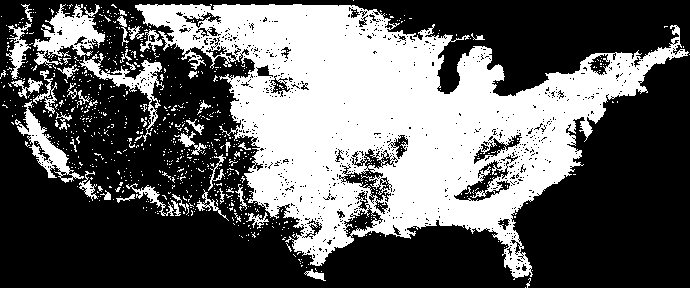

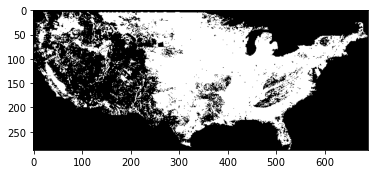

In [112]:
from matplotlib.pyplot import imshow
%matplotlib inline

from PIL import Image

im = Image.open("p_QNITROgl_irrigated.png")
display(im)
im = Image.open("p_QNITROgl_irrigated.tif")
imshow(im)

In [151]:
import pandas
file = pandas.read_csv("http://localhost:8888/files/p_CROPgl_irrigated.csv")


ParserError: Error tokenizing data. C error: Expected 1 fields in line 12, saw 2
